# Part3 - 定投策略及其有效性证明
---

In [1]:
from jqdatasdk import *
auth('13891981217','981217')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import time

提示：当前环境 pandas 版本高于 0.25，get_price 与 get_fundamentals_continuously 接口 panel 参数将固定为 False
注意：0.25 以上版本 pandas 不支持 panel，如使用该数据结构和相关函数请注意修改
auth success 


In [2]:
plt.rcParams['figure.figsize']=(15,8)

import warnings
warnings.filterwarnings("ignore")

## 1 定投策略有效性证明
### 1.1 数据获取
按照投资策略随机选取7种类别的基金，获取18年至今的净值作为验证数据

In [3]:
import requests
import execjs
import datetime
def get_fund_equity_return(fund_code, start_date, end_date):
    """
    获取特定基金在时间范围内的基金净值

    :param:
        fund_code:   基金代码
        end_date：   终止时间
    :return:
         list(dict{x:毫秒时间戳, y:基金净值})
    """
    url = 'http://fund.eastmoney.com/pingzhongdata/' + fund_code + '.js'
    content = requests.get(url).text
    jsContent = execjs.compile(content)
    trend_data = jsContent.eval('Data_netWorthTrend')

    trend = []
    for data in trend_data:
        if int(start_date) <= data['x'] / 1000 <= int(end_date):
            info = [data['x'], data['y']]
            # info = pd.DataFrame(info)
            trend.append(info)

    return trend

In [4]:
trends = pd.DataFrame()
dateLim = (datetime.datetime.now() - datetime.timedelta(days=365 * 3 + 240)).timestamp()
now = datetime.datetime.now().timestamp()

samples = ['001008', '002333', '001171', '004858', '000996', '005035', '004784']

for fundCode in samples:
    daily_data = get_fund_equity_return(fundCode, dateLim, now)
    trend = pd.DataFrame({'code': str(fundCode)}, index=[0])
    for data in daily_data:
        time_local = time.localtime(data[0] / 1000)
        dt = time.strftime("%Y-%m-%d", time_local)
        trend[dt] = data[1]
    if trends.empty:
        trends = trend
    else:
        trends = pd.concat([trends, trend], ignore_index=True)
        
panel_combine = pd.DataFrame()
panel_combine['close'] = (trends.T.sum(axis = 1) / 7)[2:]

# 增加日回报率列
panel_combine['return'] =panel_combine['close'].pct_change()

panel_combine.index = pd.DatetimeIndex(panel_combine.index)
panel_combine

,close,return
2017-08-31,0.721486,NaN
2017-09-01,0.723800,0.003208
2017-09-04,0.725700,0.002625
2017-09-05,0.727414,0.002362
2017-09-06,0.726286,-0.001551
...,...,...
2021-04-19,1.840657,0.034110
2021-04-20,1.847600,0.003772
2021-04-21,1.853986,0.003456
2021-04-22,1.870643,0.008985


选择2018至2020年数据作为定投效果的研究样本。筛选数据并作图查看分布。

In [5]:
df = panel_combine['2018-01-01':'2020-12-31'].dropna(how='any')
df

,close,return
2018-01-02,1.041200,0.013404
2018-01-03,1.049700,0.008164
2018-01-04,1.055371,0.005403
2018-01-05,1.053400,-0.001868
2018-01-08,1.056414,0.002861
...,...,...
2020-12-25,1.758686,0.012435
2020-12-28,1.756386,-0.001308
2020-12-29,1.740171,-0.009232
2020-12-30,1.775871,0.020515


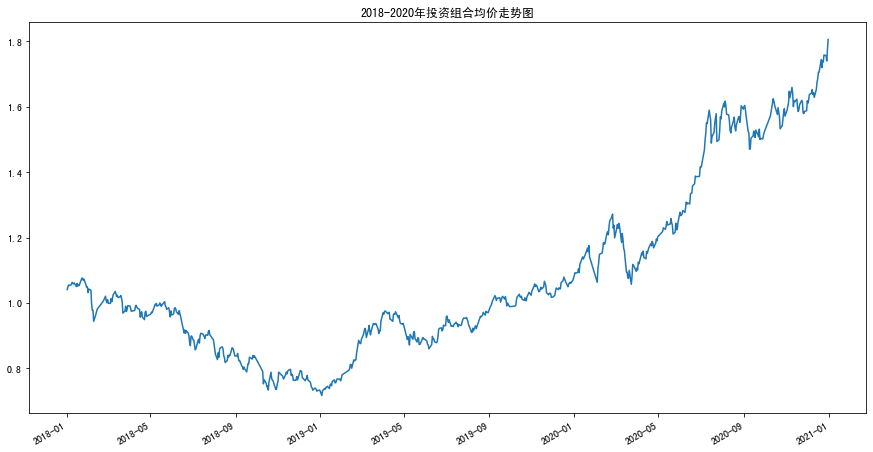

In [6]:
df['close'].plot()
plt.title('2018-2020年投资组合均价走势图')
plt.show()

### 1.2 投资效果比较
假设投资总预算为每期2000元，定投以月为周期进行投资，对比从2018年到2020年实施几种投资策略的收益率情况  
#### 1.2.1 一次性投资
由于假定定投的总投资期数为36期，因此一次性投资的本金设置为 2000*36 = 72000 元

In [7]:
df20 = df

In [8]:
TOTAL_BUDGET = 2000 * 36
frequence = 30

In [9]:
# 2018年第一个交易日买入，计算持有份额
share = TOTAL_BUDGET / df20['close'][0]

# 2020年最后一个交易日卖出，计算利润
profile_one_time = round(share * df20['close'][-1] - TOTAL_BUDGET, 2)

In [10]:
amount_log=[]
amount = TOTAL_BUDGET
invest_amount_log = []
positive_count = 0

for date, per_share in zip(df20.index, df20['close']):
    # 计算当天持有基金总值
    amount = round(share * per_share, 2)       
    amount_log.append(amount)
    
    # 投资总额始终不变
    invest_amount_log.append(TOTAL_BUDGET)
    
    # 计数是否盈利
    if amount > TOTAL_BUDGET:
        positive_count += 1

# 整理结果 
res = pd.DataFrame({
    "日期":     df20.index,
    "账户资产": amount_log,
    "投资金额": invest_amount_log
})
res = res.set_index("日期")

作图显示投资结果

2018年-2020年 一次性投资结果：
总投资：     72000
总收益：     52873.83
收益率:      73.4359 %
盈利日占比： 40.1091 %


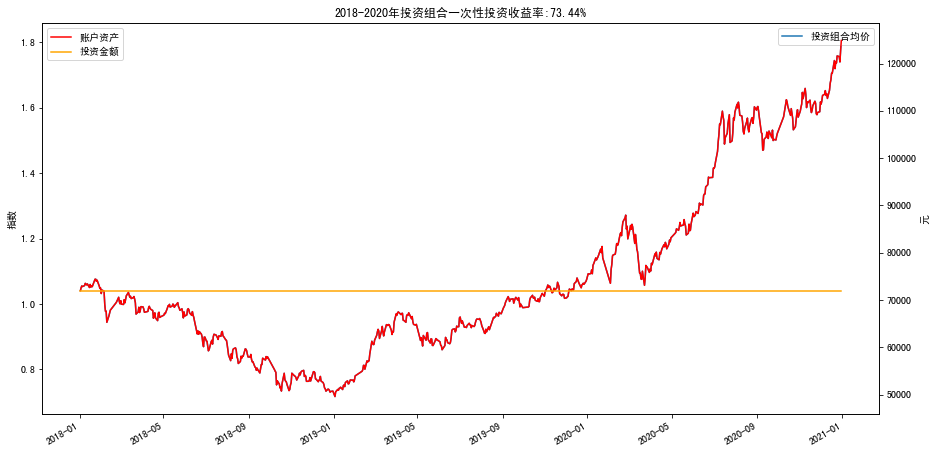

In [11]:
print("2018年-2020年 一次性投资结果：")
print("总投资：    ", TOTAL_BUDGET)
print("总收益：    ", profile_one_time)
print("收益率:     ", round(profile_one_time / TOTAL_BUDGET * 100, 4),"%")
print("盈利日占比：", round(positive_count / len(df20) * 100, 4),"%")
    
plt.figure()
df20['close'].plot(label = "投资组合均价")
plt.legend(loc = 'upper right')
plt.ylabel("指数")
plt.twinx()

res['账户资产'].plot(color = "red")
res['投资金额'].plot(color = "orange")
plt.ylabel("元")
plt.legend()
plt.title("2018-2020年投资组合一次性投资收益率:{:.2f}%".format(profile_one_time / TOTAL_BUDGET * 100))
plt.show()

#### 1.2.2 定时定额定投   
定义定投策略

In [12]:
invest_money = 2000
start_time = np.datetime64("2018-01-02")

invest_log  ={}           # 每次定投的日期记录(日期:大盘指数)
invest_day = start_time   # 每次投资的时间
invest_amount = 0         # 总投资金额
profile = 0               # 总投资收益
amount = 0                # 账户总资产
count = 0                 # 期数计数
positive_count = 0        # 盈利日

invest_amount_log=[]      # 账户投资金额日志
amount_log=[]             # 总资产日志
Yield=[]                  # 收益率日志

for date,quote_change,index in zip(df20.index,df20['return'],df20['close']):
    profile += quote_change * amount#计算当天收益率


    #判断是否为定投日
    if date == invest_day:
        count  = count + 1
        invest_amount += invest_money
        invest_log[invest_day] = index#记录定投当日的指数

        #判断7天后是否为交易日,如果不是则往后加1天直到找到交易日
        invest_day += np.timedelta64(frequence,'D')
        flag = 0
        while(True):
            if(df20[df20.index == invest_day].index == invest_day):
                break
            else:
                invest_day += np.timedelta64(1,'D')
                flag += 1
                if(flag == 100):
                    break


    invest_amount_log.append(invest_amount)
    amount=invest_amount+profile#更新账户总资产
    amount_log.append(amount)
    
    # 计数是否盈利
    if amount > invest_amount:
        positive_count += 1

    try:
        Yield.append(profile/invest_amount*100)#更新收益率
    except:
        Yield.append(0)

# 构建结果
res = pd.DataFrame({
    "日期":df20.index,
    "收益率":Yield,
    "账户资产":amount_log,
    "投资金额":invest_amount_log
})
res = res.set_index("日期")

2018年-2020年 普通定投策略结果：
定投期数：   36
总投资：     72000
总收益：     55453.98
收益率:      77.0194 %
盈利日占比： 64.3929 %


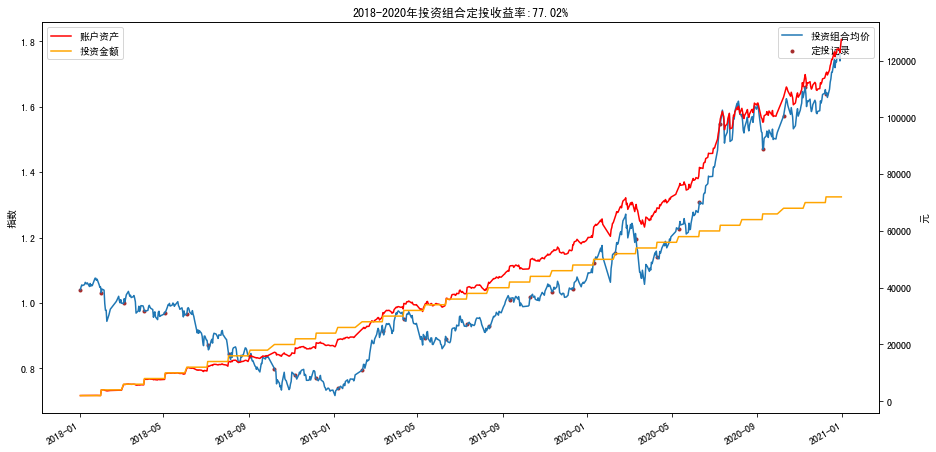

In [13]:
print("2018年-2020年 普通定投策略结果：")
print("定投期数：  ", count)
print("总投资：    ", invest_amount)
print("总收益：    ", round(profile, 2))
print("收益率:     ", round(profile / invest_amount * 100, 4),"%")
print("盈利日占比：", round(positive_count / len(df20) * 100, 4),"%")


# 作图
plt.figure()
df20['close'].plot(label="投资组合均价")
plt.scatter(invest_log.keys(),invest_log.values(),color="brown",marker=".",label="定投记录")
plt.legend(loc='upper right')
plt.ylabel("指数")
plt.twinx()

res['账户资产'].plot(color="red")
res['投资金额'].plot(color="orange")
plt.ylabel("元")
plt.legend()
plt.title("2018-2020年投资组合定投收益率:{:.2f}%".format(res.tail(1)["收益率"][0]))
plt.show()

1.2.3 均线策略定投


定义定投策略(对于每个交易日前一日的收盘价)

   * 高于均线15%以内，扣款90%
   * 高于均线15-50%，扣款80%
   * 高于均线50-100% 扣款70%
   * 高于均线 100%以上 扣款60%
   
   * 近10日振幅小于5%
        * 低于均线5%以内,扣款180%
        * 低于均线5-10%以内,扣款190%
        * 低于均线10-20%以内，扣款200%
        * 低于均线20-30%以内，扣款210%
        * 低于均线30-40%以内，扣款220%
        * 低于均线40%以上，扣款230%
        
   * 近10日振幅大于5%
        * 低于均线5%以内,扣款60%
        * 低于均线5-10%以内,扣款70%
        * 低于均线10-20%以内，扣款80%
        * 低于均线20-30%以内，扣款90%
        * 低于均线30-40%以内，扣款100%
        * 低于均线40%以上，扣款110%

In [14]:
# 定义定投策略
def stratege(ave,amp,T_1):
    '''
    定投策略
    :param ave:均线
    :param amp:振幅
    :param T_1:前1日收盘价
    '''
    cal=T_1 / ave - 1
    
    # 高于均线时
    if cal >= 0:
        if cal < 0.15:
            return 0.9
        if cal < 0.5:
            return 0.8
        if cal < 0.7:
            return 0.7
        return 0.6
    
    # 低于均线时
    # 振幅小于5%
    if amp < 0.05:
        if cal > -0.05:
            return 1.8
        if cal > -0.1:
            return 1.9
        if cal > -0.2:
            return 2.0
        if cal > -0.3:
            return 2.1
        if cal > -0.4:
            return 2.2
        return 2.3
    # 振幅大于5%
    else:
        if cal > -0.05:
            return 0.6
        if cal > -0.1:
            return 0.7
        if cal > -0.2:
            return 0.8
        if cal > -0.3:
            return 0.9
        if cal > -0.4:
            return 1.0
        return 1.1
    
    return 1

In [15]:
# 计算120日均线
average = []
for i in df20.index:
    ave = panel_combine[:i][-120:]['close'].mean()
    average.append(ave)

In [16]:
# 计算10日振幅
amplitude = []
for i in df20.index:
    interval = panel_combine[:i][-10:]['close']
    
    #最大涨跌幅
    amp = interval.max() / interval.min() - 1 
    amplitude.append(amp)

In [17]:
invest_log  ={}           # 每次定投的日期记录(日期:大盘指数)
invest_day = start_time   # 每次投资的时间
invest_amount = 0         # 总投资金额
profile = 0               # 总投资收益
amount = 0                # 账户总资产
count = 0                 # 期数计数
positive_count = 0        # 盈利日

invest_amount_log=[]      # 账户投资金额日志
amount_log=[]             # 总资产日志
Yield=[]                  # 收益率日志

for date,quote_change,index,ml,wl in zip(df20.index, df20['return'], df20['close'], average, amplitude):
    profile += quote_change * amount    #计算当天收益率
    
    # 判断是否为定投日
    if date == invest_day:
        if(invest_day == start_time):
            T_1 = start_time
        else:
            formal_day = 1
            while(True):
                T_1 = date - np.timedelta64(formal_day, "D")#前1天的收盘价
                if(T_1 in df20.index.tolist()):
                    break
                else:
                    formal_day += 1
        T_1 = df20[df20.index == T_1]["close"][0]
        rate = stratege(ml,wl,T_1)
        invest_amount += invest_money * rate#定投
        invest_log[invest_day] = index#记录定投当日的指数
        count += 1

        # 判断7天后是否为交易日,如果不是则往后加1天直到找到交易日
        invest_day += np.timedelta64(frequence,'D')
        flag = 0
        while(True):
            if(df20[df20.index == invest_day].index == invest_day):
                break
            else:
                invest_day += np.timedelta64(1, 'D')
                flag += 1
                if(flag == 100):
                    break

    # 更新资产
    invest_amount_log.append(invest_amount)
    amount = invest_amount + profile
    amount_log.append(amount)
    
     # 计数是否盈利
    if amount > invest_amount:
        positive_count += 1
    
    # 更新收益率
    try:
        Yield.append(profile / invest_amount * 100)
    except:
        Yield.append(0)

res = pd.DataFrame({
    "日期":     df20.index,
    "收益率":   Yield,
    "账户资产": amount_log,
    "投资金额": invest_amount_log
})
res = res.set_index("日期")

2018年-2020年 均线定投策略结果(参考120日均线，近10日振幅)：
定投期数：   36
总投资：     71200.0
总收益：     57753.74
收益率:      81.1148 %
盈利日占比： 65.4843 %


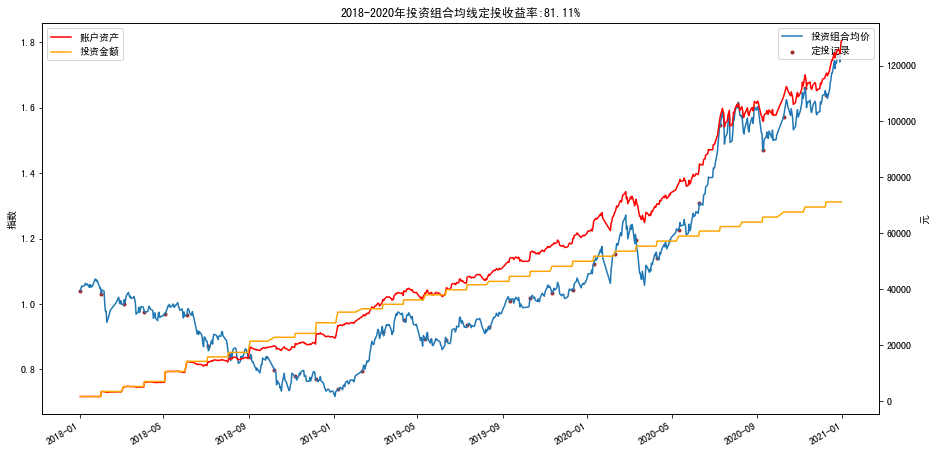

In [26]:
# myplot(df20,over,invest_log,"2018-2020年沪深300 优化定投 收益率")

print("2018年-2020年 均线定投策略结果(参考120日均线，近10日振幅)：")
print("定投期数：  ", count)
print("总投资：    ", invest_amount)
print("总收益：    ", round(profile, 2))
print("收益率:     ", round(profile / invest_amount * 100, 4),"%")
print("盈利日占比：", round(positive_count / len(df20) * 100, 4),"%")

titlename = "2018-2020年投资组合均线定投收益率"

plt.figure()
df20['close'].plot(label="投资组合均价")
plt.scatter(invest_log.keys(),invest_log.values(),color="brown",marker=".",label="定投记录")
plt.legend(loc='upper right')
plt.ylabel("指数")
plt.twinx()

res['账户资产'].plot(color="red")
res['投资金额'].plot(color="orange")

plt.ylabel("元")
plt.legend(loc='best')
plt.title(titlename+":{:.2f}%".format(res.tail(1)["收益率"][0]))
plt.show()

### 1.3 定投周期对定投效果的影响
定投周期是指开始定投到卖出基金的时长。通过对比余额宝利率（约为4%），确定定投周期对定投效果的影响。

In [19]:
panel_0 = get_price("000300.XSHG",start_date='1990-12-19', end_date='2021-04-01', frequency='1d').dropna(how='any')

# 增加日回报率列
panel_0['return'] =panel_0['close'].pct_change()

panel_0

,open,close,high,low,volume,money,return
2005-04-08,984.66,1003.45,1003.70,979.53,1.476253e+09,9.151350e+09,NaN
2005-04-11,1003.88,995.42,1008.74,992.77,1.593607e+09,1.043623e+10,-0.008002
2005-04-12,993.71,978.70,993.71,978.20,1.022619e+09,6.479563e+09,-0.016797
2005-04-13,987.95,1000.90,1006.50,987.95,1.607169e+09,1.002960e+10,0.022683
2005-04-14,1004.64,986.98,1006.42,985.58,1.294571e+09,7.813425e+09,-0.013907
...,...,...,...,...,...,...,...
2021-03-26,4953.95,5037.99,5050.83,4953.95,1.459267e+10,2.739019e+11,0.022662
2021-03-29,5052.26,5046.88,5086.65,5010.39,1.433882e+10,2.661766e+11,0.001765
2021-03-30,5043.10,5094.73,5106.04,5032.80,1.386186e+10,2.549280e+11,0.009481
2021-03-31,5085.95,5048.36,5085.95,5015.61,1.413357e+10,2.410585e+11,-0.009102


In [20]:
def Log_of_AIP(data, n, money):
    '''
    data：测试数据集，即指数历史走势数据
    n：定投周期，3个月的整数倍，如n=1代表定投3个月
    money：定投金额
    '''
    data = data.loc[:,['close','index']]
    data['trade_month'] = data['index'].apply(lambda x:str(x)[0:7])
    data['date'] = data['index']
    data = data.set_index('date').sort_index()

    # 假设余额宝的年化收益率为 4%
    data['余额宝利率'] = (4.0/100+1)**(1.0/250)-1  
    data['理财收益_净值'] = (data['余额宝利率'] + 1).cumprod()

    # 选择每个月的第一个交易日进行定投
    trading_day = data.resample('M', kind='date').first()

    # 确定循环次数，因为得保证满足定投周期
    try:
        All_Sales = pd.DataFrame()
        for i in range(len(trading_day) - (3*n)):
            # 在定投周期结束后一个月卖出
            trading_cycle = trading_day.iloc[i:i+3*n+1] 

            # 计算卖出点 下个月的指数均值
            in_month = data[data['trade_month']==list(trading_cycle['trade_month'][-1:])[0]]
            sales_point = in_month.pivot_table(values='close', index='trade_month').mean().values[0]

            # 定投指数基金
            AIP = pd.DataFrame(index=trading_cycle.index)
            AIP['定投金额'] = int(money)

            # 以基金当天的收盘价作为当天买入的价格
            AIP['基金价格'] = trading_cycle['close']
            AIP['购买基金份额'] = AIP['定投金额']/AIP['基金价格']
            AIP['累计基金份额'] = AIP['购买基金份额'].cumsum()

            # 定期购买理财产品
            AIP['购买理财产品份额'] = AIP['定投金额']/trading_cycle['理财收益_净值']
            AIP['累计理财产品份额'] = AIP['购买理财产品份额'].cumsum()

            # 累计投入本金
            AIP['累计定投本金'] = AIP['定投金额'].cumsum()

            # 计算每个交易日的本息（即本金+利息，公式=当天的份额 X 当天的基金价格）
            result = pd.concat([trading_cycle, AIP], axis=1)
            result['基金本息'] = (result['close'] * result['累计基金份额']).astype('int')
            result['理财本息'] = (result['理财收益_净值'] * result['累计理财产品份额']).astype('int')

            # 买入点 result['trade_date'][0]
            # 定投周期（月） 3*n
            # 定投投入本金 result['累计定投本金'][-2:-1][0]
            # 基金卖出后本息 result['累计基金份额'][-2:-1][0] * sales_point
            # 余额宝卖出后本息 result['理财本息'][-2:-1][0]


            Each_Sales = pd.DataFrame([[result['index'][0], 
                                       3*n, 
                                       result['累计定投本金'][-2:-1][0],
                                       result['累计基金份额'][-2:-1][0] * sales_point, 
                                       result['理财本息'][-2:-1][0]]], 
                                     columns=['买入点','定投周期(月)', '累计定投本金', '基金卖出后本息', '余额宝卖出后本息'])
            Each_Sales['基金收益率%'] = 100*(Each_Sales['基金卖出后本息'][0]/Each_Sales['累计定投本金'][0] - 1)
            Each_Sales['余额宝收益率%'] = 100*(Each_Sales['余额宝卖出后本息'][0]/Each_Sales['累计定投本金'][0] - 1)
            Each_Sales['LikeOrNot'] = Each_Sales['基金卖出后本息'] > Each_Sales['余额宝卖出后本息'] 
            All_Sales = All_Sales.append(Each_Sales)
        return All_Sales

    except:
        print("定投周期大于历史股价走势！请重新设置定投周期。")

In [21]:
like_rate = pd.DataFrame()

panel_1 = panel_0.reset_index(level=None, drop=False)
# panel_1
for i in range(int(193/3)):
    tt = Log_of_AIP(panel_1, i + 1, 2000)
    rate = pd.DataFrame([[(i+1)*3, (tt['LikeOrNot'].value_counts()/len(tt))[True]]], 
                        columns=['定投周期(月)','定投基金满意占比'])
    like_rate = like_rate.append(rate)

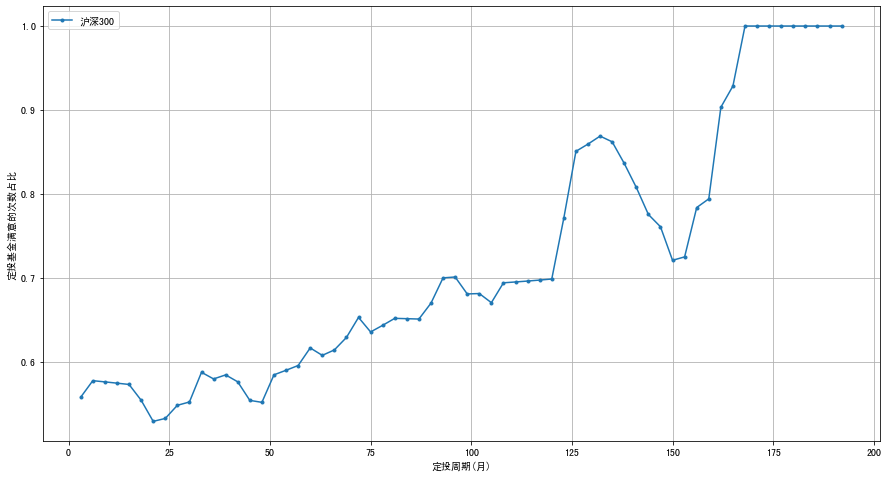

In [22]:
# 绘制定投满意概率图
plt.plot(like_rate['定投周期(月)'], like_rate['定投基金满意占比'],'.-',label = '沪深300')
plt.xlabel("定投周期(月)")
plt.ylabel("定投基金满意的次数占比")
plt.legend()
plt.grid()
plt.show()

Text(0.5, 0, '时间')

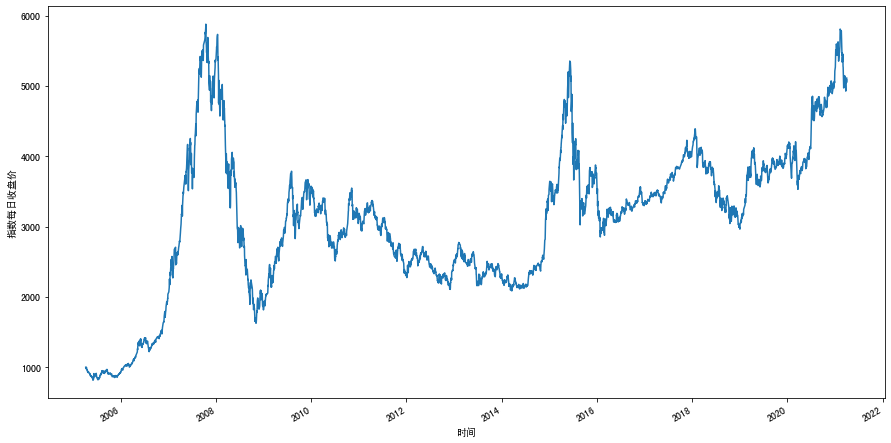

In [23]:
panel_0['close'].plot()
plt.ylabel("指数每日收盘价")
plt.xlabel("时间")